# 3.0 Build predictive model

In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
 
%matplotlib inline

In [65]:
df = pd.read_csv('model_data/tci_2_3.csv')
df.shape

(13500, 62)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13500 entries, 0 to 13499
Data columns (total 62 columns):
Unnamed: 0                                 13500 non-null int64
parcel                                     13500 non-null object
House Number                               13500 non-null int64
Street Name                                13500 non-null object
Category                                   13500 non-null object
Survey Date                                13500 non-null object
vacant                                     13500 non-null int64
zip                                        13500 non-null float64
propsize                                   13500 non-null float64
pclass                                     13500 non-null object
totusabl                                   13500 non-null float64
tmktval                                    13500 non-null float64
condition                                  13492 non-null object
condition_value                            13

#### Count missing values as a variable

In [67]:
df['missing_values'] = df.apply(lambda x: len(x[x.isnull()]),axis=1)

In [68]:
df[['missing_values','vacant']].groupby('missing_values').agg([sum,len])

vacant       
                  sum    len
missing_values              
0                 561  13464
2                  12     28
5                   0      3
7                   0      5

#### Change 'pclass' into residential/non-residential

Only use data from residential parcels in the model.

In [69]:
def fun(x):
    if x == 'Residential':
        return 1
    else:
        return 0
df['pclass_filtered'] = df['pclass'].apply(fun)

In [70]:
df[['pclass_filtered','vacant']].groupby('pclass_filtered').agg([sum,len])

vacant       
                   sum    len
pclass_filtered              
0                  550  13444
1                   23     56

In [73]:
df.shape

(13500, 64)

In [74]:
# df = df[df['pclass_filtered']==1]
# df.shape

#### Let's look at total market value, property size, etc.

In [75]:
# def is_outlier(points, thresh=3.5):
#     """
#     Returns a boolean array with True if points are outliers and False 
#     otherwise.

#     Parameters:
#     -----------
#         points : An numobservations by numdimensions array of observations
#         thresh : The modified z-score to use as a threshold. Observations with
#             a modified z-score (based on the median absolute deviation) greater
#             than this value will be classified as outliers.

#     Returns:
#     --------
#         mask : A numobservations-length boolean array.

#     References:
#     ----------
#         Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
#         Handle Outliers", The ASQC Basic References in Quality Control:
#         Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
#     """
#     if len(points.shape) == 1:
#         points = points[:,None]
#     median = np.median(points, axis=0)
#     diff = np.sum((points - median)**2, axis=-1)
#     diff = np.sqrt(diff)
#     med_abs_deviation = np.median(diff)

#     modified_z_score = 0.6745 * diff / med_abs_deviation

#     return modified_z_score > thresh

In [76]:
import seaborn as sns

In [77]:
df.head(1)

,Unnamed: 0,parcel,House Number,Street Name,Category,Survey Date,vacant,zip,propsize,pclass,...,complaint_no permit,complaint_no water,complaint_o.v.v.,complaint_plumbing,complaint_count,complaint_count_6_mon,complaint_count_3_mon,auction,missing_values,pclass_filtered
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ValueError: x must have at least one data point

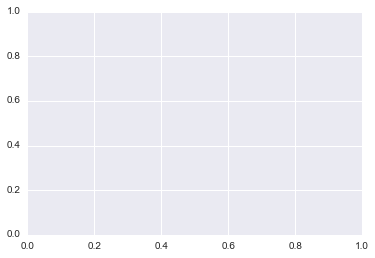

In [78]:
b = np.linspace(0, 120000, 40)
plt.hist(df.loc[(~is_outlier(df.tmktval)) & (df.vacant==1),'tmktval'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.tmktval)) & (df.vacant==0),'tmktval'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of total market value');

In [ ]:
max(df.violations_number)

In [ ]:
b = np.linspace(1, 30, 30)
plt.hist(df.loc[(df.vacant==1),'violations_number'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(df.vacant==0),'violations_number'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of number of violations (besides 0)');

In [81]:
df[['complaint_o.v.v.','vacant']].groupby('complaint_o.v.v.').agg([sum, len])

vacant       
                    sum    len
complaint_o.v.v.              
0                    14  12938
1                   559    562

In [82]:
df[['totbldgs','vacant']].groupby('totbldgs').agg([sum, len])

vacant       
            sum    len
totbldgs              
0             0  12900
1           573    598
2             0      2

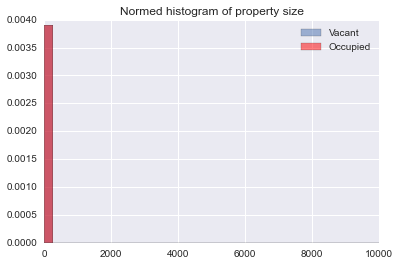

In [83]:
b = np.linspace(0, 10000, 40)
plt.hist(df.loc[(~is_outlier(df.propsize)) & (df.vacant==1),'propsize'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.propsize)) & (df.vacant==0),'propsize'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of property size');

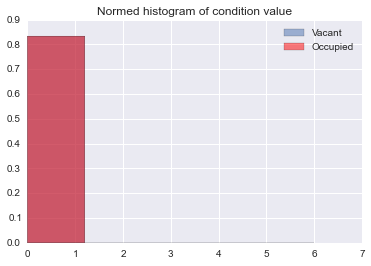

In [84]:
b = np.linspace(0, 6, 6)
plt.hist(df.loc[(~is_outlier(df.condition_value)) & (df.vacant==1),'condition_value'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.condition_value)) & (df.vacant==0),'condition_value'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of condition value');

ValueError: x must have at least one data point

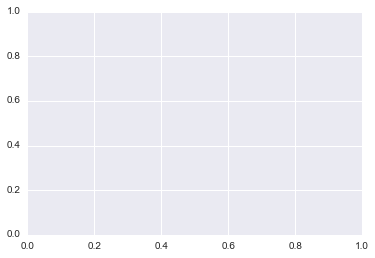

In [85]:
b = np.linspace(1900, 1950, 40)
plt.hist(df.loc[(~is_outlier(df.yrbuilt_filtered)) & (df.vacant==1),'yrbuilt_filtered'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.yrbuilt_filtered)) & (df.vacant==0),'yrbuilt_filtered'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of year built');

In [86]:
cols = ['condition_value','totbldgs','yrbuilt_filtered','vacant', \
        'num_of_sales','quit_claim_deed','warranty_deed','limited_warranty','survivorship_deed','fiduciary_deed', \
        'county_land_bank', 'vindall_Y', 'vindall_P','task_app','task_clo', 'task_con', 'task_dem', 'task_ins', \
        'task_non','task_pro','task_sea','violations_number','violation_condemnation - garage', \
        'violation_condemnation - main structure', 'violation_exterior maintenance', 'violation_fire damage', \
        'violation_interior/exterior maintenance', 'violation_no permit', 'violation_survey', \
        'complaint_collapsing structure','complaint_complete interior/exterior', 'complaint_electrical', \
        'complaint_fire damage', 'complaint_general exterior maintenance', 'complaint_grass/weeds/bushes (occupied)', \
        'complaint_grass/weeds/bushes (vacant)', 'complaint_hvac','complaint_no permit', 'complaint_no water', \
        'complaint_o.v.v.', 'complaint_plumbing', 'complaint_count','complaint_count_6_mon', 'complaint_count_3_mon','auction']

# 'propsize','totusabl','tmktval',

# cols = ['propsize','tmktval','condition_value','totbldgs','yrbuilt_filtered','vacant', \
#         'num_of_sales','quit_claim_deed','warranty_deed',
#         'violations_number', 'missing_values', 'ownerocc_value',\
#         'vindall_Y', 'complaint_count','complaint_count_6_mon', 'complaint_count_3_mon']

### Impute with median values

In [87]:
df.loc[df.propsize.isnull(),'propsize'] = np.median(df[df.propsize.notnull()].propsize)
df.loc[df.totusabl.isnull(),'totusabl'] = np.median(df[df.totusabl.notnull()].totusabl)
df.loc[df.tmktval.isnull(),'tmktval'] = np.median(df[df.tmktval.notnull()].tmktval)
df.loc[df.condition_value.isnull(),'condition_value'] = np.median(df[df.condition_value.notnull()].condition_value)
df.loc[df.totbldgs.isnull(),'totbldgs'] = np.median(df[df.totbldgs.notnull()].totbldgs)
df.loc[df.yrbuilt_filtered.isnull(),'yrbuilt_filtered'] = np.median(df[df.yrbuilt_filtered.notnull()].yrbuilt_filtered)
df.loc[df.ownerocc_value.isnull(),'ownerocc_value'] = np.median(df[df.ownerocc_value.notnull()].ownerocc_value)

In [88]:
df.groupby('rextwall').count()['vacant']

rextwall
0                       12893
1                         549
Aluminum/Vinyl (r)         22
Asbestos Shingle (r)        1
Brick                       7
Frame (r)                  18
Frame/Brick (r)             1
Name: vacant, dtype: int64

In [89]:
ext = pd.DataFrame(df.groupby('rextwall').count()['vacant'])
ext.columns = ['rextwall']
ext_set = set(ext[ext.rextwall > 200].index)

In [90]:
ext_set

{'0', '1'}

In [91]:
ext_set.add('Other')

In [92]:
def check_var(x):
    if x in ext_set:
        return x
    else:
        return 'Other'
    
def check_wall(x, wall):
    if x == wall:
        return 1
    else:
        return 0
        
df['rextwall'] = df['rextwall'].apply(check_var)

for wall in ext_set:
    df['ext_'+wall.lower()] = df['rextwall'].apply(lambda x: check_wall(x, wall))

In [93]:
df.loc[df.rextwall.notnull(),['rextwall','vacant']].groupby('rextwall').agg([sum,len])

vacant       
            sum    len
rextwall              
0             0  12893
1           549    549
Other        24     58

In [94]:
# transform categorical variables (including NaN's)
df2 = df[['style_filtered', 'rextwall']]#,'mult_name_flag','SALE_VALID']]
prefixes = ['style','extwall']#,'mult_name','sale_valid']#,'LUC']
df3 = pd.concat([pd.get_dummies(df2[col], prefix=prefixes[index]) for index, col in enumerate(df2)], axis=1)

In [95]:
features = list(cols)
features.remove('yrbuilt_filtered')
# features.remove('tmktval')
features.remove('totbldgs')

In [96]:
df3[features] = df[features]

In [97]:
# for c in df3.columns:
#     print c, len(df3[df3[c].isnull()])

## Build the classifiers

In [98]:
from sklearn.cross_validation import cross_val_score

In [99]:
# train and test the classifier, look at results in a cross tabulation
# NOTE: we can get probabilities instead of a prediction!

# take out half the data for the test set
df3['is_train'] = np.random.uniform(0, 1, len(df3)) <= .7
train, test = df3[df3['is_train']==True], df3[df3['is_train']==False]
 
# features = list(df3.columns)
features.remove('vacant')

y, _ = pd.factorize(train['vacant'])

In [100]:
print df3.shape

(13500, 53)


In [101]:
test_label = test.vacant

### Random Forest Classifier

In [102]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, \
                             class_weight=None, \
                             max_features=None, random_state=0, max_depth=22)
# rf = RandomForestClassifier(n_estimators=10, criterion='gini', \
#                                    , min_samples_split=2, min_samples_leaf=1,\
#                                    max_features='auto', max_leaf_nodes=None, bootstrap=True,\
#                                    oob_score=False, n_jobs=1, random_state=None, verbose=0,\
#                                    min_density=None, compute_importances=None)

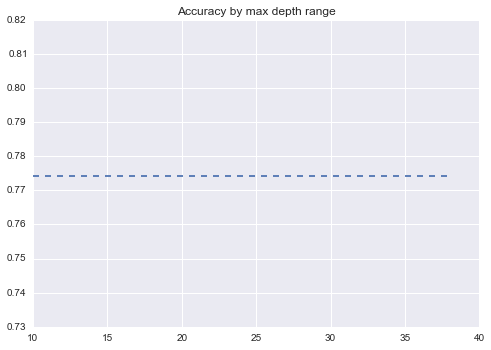

In [38]:
depth_range = range(10,40,2)
scores = []
for depth in depth_range:
    rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=depth)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(depth_range, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by max depth range');

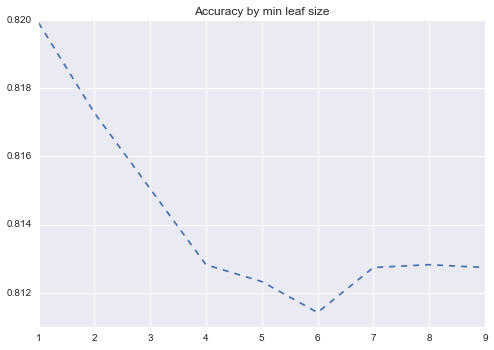

In [58]:
leafs = range(1,10,1)
scores = []
for leaf in leafs:
    rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=leaf, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=20)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by min leaf size');

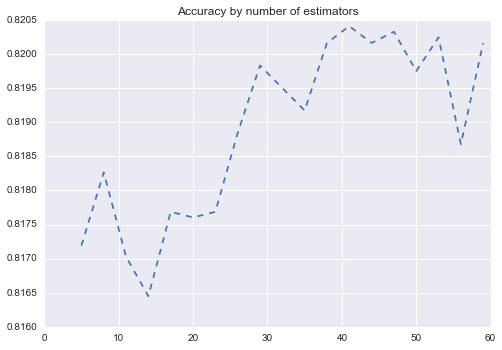

In [59]:
ests = range(5,60,3)
scores = []
for e in ests:
    rfc = RandomForestClassifier(n_estimators=e, min_samples_leaf=1, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=22)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(ests, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by number of estimators');

In [142]:
# param_grid = { 
# #     'n_estimators': [100, 700],
# #     'class_weight': ['auto',None],
#     'min_samples_leaf': [2,4,6],
#     'max_depth': [9,12,16]
# }
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
# CV_rfc.fit(train[features], y)
# print CV_rfc.best_params_

In [103]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=25)
rfc = rfc.fit(train[features], y)

In [104]:
rfc_prob = rfc.predict_proba(test[features])

In [105]:
preds = rfc.predict(test[features])
pd.crosstab(test['vacant'], preds, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,3852,2
1,3,168


Feature ranking:
1. feature 0, condition_value (0.973657)
2. feature 3, warranty_deed (0.020156)
3. feature 8, vindall_Y (0.004737)
4. feature 1, num_of_sales (0.000629)
5. feature 38, complaint_count (0.000478)
6. feature 36, complaint_o.v.v. (0.000144)
7. feature 4, limited_warranty (0.000064)
8. feature 39, complaint_count_6_mon (0.000056)
9. feature 27, complaint_complete interior/exterior (0.000028)
10. feature 2, quit_claim_deed (0.000025)


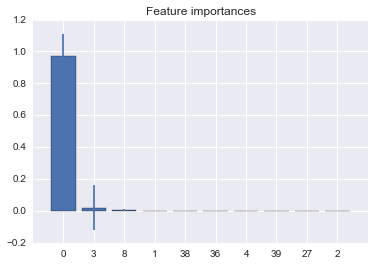

In [106]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

### Adaboost Classifier

In [107]:
from sklearn.ensemble import AdaBoostClassifier

In [108]:
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
abc.fit(train[features], y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0)

In [109]:
cross_val_score(abc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.99896301746687932

In [110]:
abc_prob = abc.predict_proba(test[features])

In [111]:
pd.crosstab(test['vacant'], abc.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,3852,2
1,3,168


### Single decision tree

In [112]:
from sklearn import tree

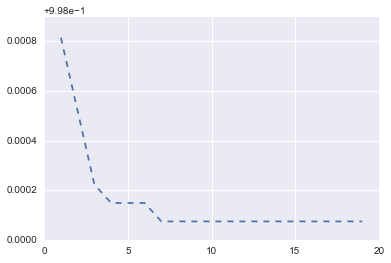

In [113]:
leafs = range(1,20,1)
scores = []
for leaf in leafs:
    clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=leaf)
    scores.append(cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');

In [114]:
clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=1)
clf = clf.fit(train[features], y)

In [115]:
cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.99874090490279799

In [116]:
pd.crosstab(test['vacant'], clf.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,3852,2
1,3,168


### Support Vector Machines

The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10,000 samples.

In [82]:
from sklearn import svm
# kernels = ['rbf','poly','linear','sigmoid']
# scores = []
# for k in kernels:
#     svm_mod = svm.SVC(class_weight='auto', kernel=k, random_state=0)
#     scores.append(cross_val_score(svm_mod, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
# print scores
svm_mod = svm.SVC(class_weight='auto', kernel='rbf', random_state=0)
svm_mod.fit(train[features], y)  

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [83]:
# linear
pd.crosstab(test['vacant'], svm_mod.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,2749,402
1,187,280


### K-nearest neighbors

In [84]:
from sklearn import preprocessing
from sklearn import neighbors

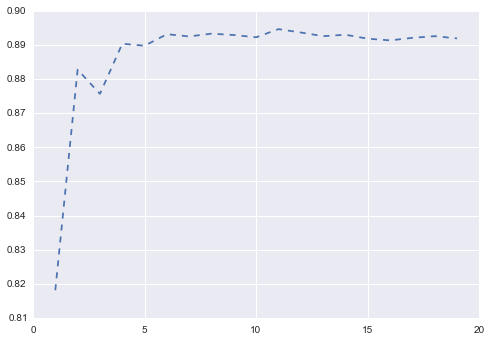

In [86]:
neighs = range(1,20)
scores = []
for n in neighs:
    knn = neighbors.KNeighborsClassifier(n_neighbors=n, weights='uniform')
    scores.append(cross_val_score(knn, (df3[features]), df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(neighs,scores,'--');

In [87]:
knn = neighbors.KNeighborsClassifier(n_neighbors=8, weights='uniform')
knn.fit(train[features], y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=8, p=2, weights='uniform')

In [88]:
pd.crosstab(test['vacant'], knn.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,3088,63
1,347,120


In [89]:
knn_prob = knn.predict_proba(test[features])

In [90]:
avg = (knn_prob+rfc_prob*2.0+abc_prob)/4.0

In [91]:
preds = avg[:,1].round()

In [92]:
pd.crosstab(test['vacant'], preds, rownames=['actual'], colnames=['preds'])

preds,0.0,1.0
actual,,
0,2992,159
1,257,210


In [93]:
(2992+210.0)/len(test)

0.8850193477059148

## xgboost

In [67]:
# train = pd.read_csv('data/train.csv', index_col=0)
# test = pd.read_csv('data/test.csv', index_col=0)
labels = train.vacant
train.drop('vacant', axis=1, inplace=True)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
import xgboost as xgb

columns = train.columns
test_ind = test.index

train = np.array(train)
test = np.array(test)
# # label encode the categorical variables
# for i in range(train.shape[1]):
#     if type(train[1,i]) is str:
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(train[:,i]) + list(test[:,i]))
#         train[:,i] = lbl.transform(train[:,i])
#         test[:,i] = lbl.transform(test[:,i])

train = train.astype(float)
test = test.astype(float)

In [135]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.01
params["min_child_weight"] = 1
params["subsample"] = 0.8
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 20
params["booster"] = 'gbtree'

plst = list(params.items())

#Using 5000 rows for early stopping. 
offset = 0
num_rounds = 2000

In [136]:
xgtest = xgb.DMatrix(test)
#create train and validation dmatrices 
xgtrain = xgb.DMatrix(train, label=labels)
# xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

In [137]:
#train using early stopping and predict
watchlist = [(xgtrain, 'train'),(xgval, 'val')]
model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=5)
preds1 = model.predict(xgtest)
preds1a = model.predict(xgtrain)

#reverse train and labels and use different 5k for early stopping. 
# this adds very little to the score but it is an option if you are concerned about using all the data. 
train = train[::-1,:]
labels = labels[::-1]

xgtrain = xgb.DMatrix(train[offset:,:], label=labels[offset:])
xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

watchlist = [(xgtrain, 'train'),(xgval, 'val')]
model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=5)
preds2 = model.predict(xgtest)
preds2a = model.predict(xgtrain)

# scores.append(gini(preds1a+preds2a, labels[offset:]))

Will train until val error hasn't decreased in 5 rounds.


XGBoostError: label set cannot be empty

In [138]:
pd.crosstab(test_label, (preds1/2+preds2/2+0.037).round(), rownames=['actual'], colnames=['preds']) 

preds,0.0,1.0
actual,,
0,3001,175
1,301,168


In [125]:
pd.crosstab(labels, (preds1a/2+preds2a/2).round(), rownames=['actual'], colnames=['preds']) 

ValueError: array length 3477 does not match index length 8477

In [127]:
labels.shape

(8477,)

In [129]:
preds2a.shape

(3477,)

In [131]:
xgtrain